In [22]:
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm
import datetime
# import nc_time_axis
# from cftime import DatetimeNoLeap
import numpy as np
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
from braceexpand import braceexpand
import pandas as pd
from math import cos, asin, sqrt, pi
%matplotlib inline
%config InlineBackend.figure_format='retina'
# This code make the next section of code to stop acting silly
dask.config.set({"array.slicing.split_large_chunks": True})
	# True: smaller chunks are used
	# False: large chunks are accepted

#### Functions

In [5]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.

def assign_LT_coord(da):
	hour_offset = (da.lon.values/15).round(decimals=0)
	hour_offset = hour_offset.repeat(len(da.time)).reshape((len(da.lon),len(da.time))).T
	local_time = np.empty([len(da.time),len(da.lon)], dtype=object)
	for i in range(local_time.shape[0]):
		for j in range(local_time.shape[1]):
			local_time[i,j] = da.time.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
	da = da.assign_coords(LocalTime=(('time','lon'),local_time))
	return da

In [6]:
def hov_diurnal(da):
    # Average over the bounds to create shape of (time,west_east)
    da_avg = da.where((da.lat>lat_avg_bound[0])&(da.lat<lat_avg_bound[1]),drop=True).mean(dim='lat')
    # Create a np.array with shape (west_east,hour). Then populate each longitude column with its respective
        # diurnal cycle of rain rate.
    array = np.zeros((da_avg.shape[1],24))
    # Loop through each longitude, look through all the timesteps and group them by hour,
        # and then average the values at each hour. Output the 1x24 array into the empty array
    for i in range(array.shape[0]):
        array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()
    return array

In [7]:
# Purpose: Rotate a vectorized variable like a wind vector in x/lon and y/lat space!
	# See Lecture02_Vector.pdf in METR 5113 Advanced Atmospheric Dynamics folder

# Input:
    # da_x  = 		xr.data_array		 	# Should be the X component of the vector
    # da_y  = 		xr.data_array			# Should be the Y component of the vector
		# Can be one time step or pressure level or even a 4-D variable [Time x Height x Lat x Lon]
    # theta =		rotation in radians		
		# Must be -pi/2 < theta < pi/2, you don't need to rotate any more than the 180° provided
		# Positive theta indiates anticlockwise turn of coordinates
		# Negative theta indiates clockwise turn of coordinates
# Output:
    # da_x_rot:		da_x but rotated
	# da_y_rot:		da_y but rotated
# Process:
    # Check if theta is positive or negative
		# Based on the value, the projections using theta will change
	# Project the current x and y coordinate to the new rotated x and y coordinates for each component.
	# Once rotated, return the rotated x and y components
# Example:
	# da_x = da_d01_U
	# da_y = da_d01_V
	# theta = pi/4	# 45° rotation anti-clockwise
	# da_d01_U_rotated, da_d01_V_rotated = rotate_vec(da_x, da_y, theta)

def rotate_vec(da_x, da_y, theta):
	# anti-clockwise rotation
	if theta > 0:
		da_x_rot = da_x*cos(theta) + da_y*cos((pi/2)-theta)
		da_y_rot = da_x*cos((pi/2)-theta) + da_y*cos(theta)
	# clockwise rotation
	if theta < 0:
		da_x_rot = da_x*cos(-theta) + da_y*cos((pi/2)+theta)
		da_y_rot = da_x*cos((pi/2)+theta) + da_y*cos(-theta)

	return da_x_rot, da_y_rot

In [20]:
# Purpose: Create an array with multiple cross-sectional data from WRFoutput.
# Input:
    # da = 			xr.data_array		 	works with both 2-D and 3-D variables!
    # start_coord = [latitude, longitude] 
    # end_coord = 	[latitude, longitude]
	# width = 		spread of cross-section in degrees i.e., 0.75° = 0.75
	# dx = 			distance between each cross-sectional line i.e., 0.05° = 0.05
# Output:
    # da_cross: 	matrix in time, height, distance, and # of lines
	# 					or time, distance, and # of lines if using a 2-D variable
# Process:
	# Make sure you 'da' have assigned coordinates corresponding to lat and lon.
    # We first create a main line between start_coord -> end_coord. This line will be the center
		# line for all other lines to sit next to.
	# Depending on the angle of the line (more latitudinal change or longitudinal change), this
		# function will account for that and make the longest side the length of the cross-sectional line
	# We then create an empty np.array, calculate the change in spread needed, then start filling in the data.

def cross_section_multi(da, start_coord, end_coord, width, dx):

	# We want to first create a line between start and end_coords
		# Gather the indicies of the closest gridboxes of start and end_coords.
	start_ilat = int((abs((da.lat) - (start_coord[0]))).argmin())
	end_ilat = int((abs((da.lat) - (end_coord[0]))).argmin())
	start_ilon = int((abs((da.lon) - (start_coord[1]))).argmin())
	end_ilon = int((abs((da.lon) - (end_coord[1]))).argmin())
	# This statement ensures that the length of the line will be the size of the LONGEST side (either lat or lon)
	if abs(start_ilat-end_ilat)>=abs(start_ilon-end_ilon):
		line_coords = np.zeros([2,abs(start_ilat-end_ilat)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.lat[start_ilat], da.lat[end_ilat], abs(start_ilat-end_ilat))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.lon[start_ilon], da.lon[end_ilon], abs(start_ilat-end_ilat))
	else:
		line_coords = np.zeros([2,abs(start_ilon-end_ilon)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.lat[start_ilat], da.lat[end_ilat], abs(start_ilon-end_ilon))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.lon[start_ilon], da.lon[end_ilon], abs(start_ilon-end_ilon))

	##########################################################################################################################
	# Now that we have the coordinates between the start and end_coords, we need to replicate it for all the lines
	num_lines = int(width/dx)
	spread = np.arange(width/2,-width/2,-dx)
	if 'bottom_top' in da.dims:	# If the dataset is 3-D
		#						TIME	x	HEIGHT	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],da.shape[1],line_coords.shape[1],num_lines])
	else:
		#						TIME	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],line_coords.shape[1],num_lines])

	# Create all_line_coords that holds all the coordinates for every line produced
	all_line_coords = np.zeros([line_coords.shape[0],line_coords.shape[1],spread.shape[0]])

	# Looping over all the lines
	for i in range(len(spread)):
		# Now that we have our lines, we can interpolate the dataset with the offset for each line applied
		da_interp = da.interp(lat=line_coords[0,:]+spread[i], lon=line_coords[1,:]-spread[i], method="linear")

		# Populate the new data array with data from the cross section
			# Loop through the length of the line, find the match, and then populate it.
		if 'bottom_top' in da.dims:	# If the dataset is 3-D
			for j in range(da_cross.shape[2]):
				data = da_interp.sel(
					lat = da_interp.lat[j],
					lon = da_interp.lon[j])
				da_cross[:,:,j,i] = data
		else:
			for j in range(da_cross.shape[1]):
				data = da_interp.sel(
					lat = da_interp.lat[j],
					lon = da_interp.lon[j])
				da_cross[:,j,i] = data

		all_line_coords[0,:,i] = line_coords[0,:]+spread[i]
		all_line_coords[1,:,i] = line_coords[1,:]-spread[i]

	return da_cross, all_line_coords

In [9]:
def dist(lat1, lon1, lat2, lon2):
    r = 6371 # km
    p = pi / 180

    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))

In [10]:
# Purpose: To alliviate the memory issue that arrises when you getvar() a big dataset.
# Input:
    # xrDataset = xr.open_dataset(filepath)
    # Dataset = Dataset(filepath)
    # varname = '<variablename>'
# Output:
    # da: This will be the xr.DataArray you are after
# Process:
    # First create an empty np.array that holds varname values.
    # Loop through each timestep to fill in the np.array.
    # Here's the trick, only getvar() one timestep, then expand the time dim.
        # This will repeate the values from the first timestep into the Time dim.
    # Assign the Time coordinates.
    # Replace the repeated values with the correct values from npArray.

# This method is ~6x more efficient than getvar(Dataset, varname, ALL_TIMES)

def wrf_np2da(xrDataset,Dataset,varname):
    da_times = getvar(Dataset, 'times', ALL_TIMES)			# Times in datetime64
    # Create empty numpy array
    npArray = np.empty((xrDataset.dims['Time'],xrDataset.dims['bottom_top'],
                        xrDataset.dims['south_north'],xrDataset.dims['west_east']),np.float32)
    for i in range(npArray.shape[0]):
        npArray[i,...] = getvar(Dataset, varname, timeidx=i, meta=False)
    da = getvar(Dataset, varname, timeidx=0)
    da = da.expand_dims(dim={'Time': da_times}, axis=0)
    da = da.assign_coords(dict(
        Time=('Time',da_times.values),
        XTIME=('Time',np.float32(xrDataset['ITIMESTEP'].values))
    ))
    da.values = npArray
    return da

In [11]:
def da_info(da):
    print('Description: ', da.description, '\nUnits: ',da.units, '\nDimensions: ', da.dims, '\nShape: ', da.shape)

#### Global Variables

In [80]:
# Set the bounds you want to look at
lat_bound = [-10,10]		# South to North
lon_bound_d01 = [80,135]	# West to East
lon_bound_d02 = [90,125]	# West to East
lat_avg_bound = [-5,5]

In [81]:

## IMERG rainfall rates just for Nov 22 - Dec 3
ds_RR_IMERG = xr.open_dataset('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/IMERG_2015-11-22-12:00-12-03-00:00.nc')
# Change coordinates from +-180° to 0-360°
ds_RR_IMERG = ds_RR_IMERG.assign_coords(lon=(ds_RR_IMERG.lon % 360)).sortby('lon')
da_RR_IMERG = ds_RR_IMERG['precipitationCal'].compute()
# Change to times for IMERG data to datetime
	# https://stackoverflow.com/questions/55786995/converting-cftime-datetimejulian-to-datetime
datetimeindex = da_RR_IMERG.indexes['time'].to_datetimeindex()
da_RR_IMERG = da_RR_IMERG.assign_coords(time=datetimeindex)
da_RR_IMERG = da_RR_IMERG.transpose('time','lat','lon')
da_RR_IMERG = assign_LT_coord(da_RR_IMERG)
print('This is the size of the IMERG data array in (time,lat,lon): ', da_RR_IMERG.shape)

# IMERG Land-Sea Mask
# The file displays percent water surface coverage with 100% = all water and 0% = all land.
# Land sea is also called land ocean or land water. 
# Typical percentage thresholds used to define sea are 100% (strictly open water) 
	# or 75% (including sea-ward coast areas). 
# Typical percentages used to define strictly land are 25% or 15%; 
	# too low a percentage masks out humid regions that have many lakes and reservoirs.

ds_Mask_IMERG = xr.open_dataset('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/obs_data/IMERG_land_sea_mask.nc')
# Change coordinates from +-180° to 0-360°
ds_Mask_IMERG = ds_Mask_IMERG.assign_coords(lon=(ds_Mask_IMERG.lon % 360)).sortby('lon')
da_Mask_IMERG = ds_Mask_IMERG['landseamask'].sel(
    lon=slice(lon_bound_d01[0],lon_bound_d01[1]),
	lat=slice(lat_bound[0],lat_bound[1])
).compute()
# Repeat it so that a time dimension is added
x = da_Mask_IMERG.values.repeat(len(da_RR_IMERG.time)).reshape((len(da_Mask_IMERG.lat),
                                                            len(da_Mask_IMERG.lon),
                                                            len(da_RR_IMERG.time)))
x = np.transpose(x, (2,0,1))
da_Mask_IMERG = xr.DataArray(
    data = x,
    dims = ['time','lat','lon'],
    coords = dict(
        lat=('lat',da_RR_IMERG.lat.values),
        lon=('lon',da_RR_IMERG.lon.values),
        time=('time',da_RR_IMERG.time.values)
        ))

/tmp/ipykernel_47358/2849711858.py:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = da_RR_IMERG.indexes['time'].to_datetimeindex()


This is the size of the IMERG data array in (time,lat,lon):  (505, 200, 550)


#### Cross Sectional Analysis

In [103]:
# Collect the cross sectional data from the now rotated coordinate system
start_coord		= [-1.8,103.8]
end_coord 		= [-5.8,99.8]
width			= 1.5
dx 				= 0.025
# Same analysis but with rain rate
da_cross_temp, all_line_coords = cross_section_multi(da_RR_IMERG, start_coord, end_coord, width, dx)

distance = np.linspace(0,dist(start_coord[0], start_coord[1], end_coord[0], end_coord[1]),da_cross_temp.shape[1])
# d01 coast
distance = distance - distance[18]

da_d01_RR_cross = xr.DataArray(
	data=da_cross_temp,
	dims=('Time','Distance','Spread'),
	coords={'Time':da_RR_IMERG['time'].values,
		 'Distance':distance,
		 'Spread':np.arange(width/2,-width/2,-dx),
		 'Lat': (('Distance','Spread'), all_line_coords[0,:,:]),
		 'Lon': (('Distance','Spread'), all_line_coords[1,:,:])}
	)

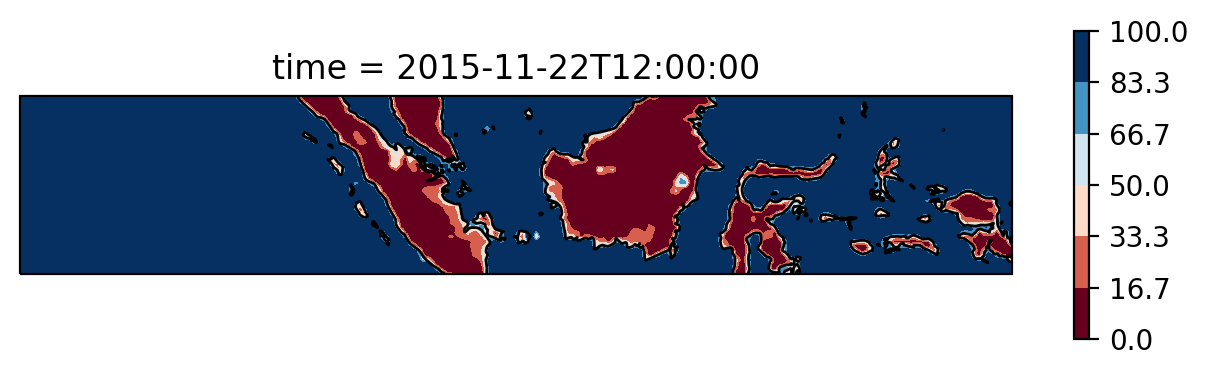

In [74]:
# Testing IMERG MASK
fig = plt.figure(figsize=(8,2))
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
# cf1 = da_Mask_IMERG[0,...].where(da_Mask_IMERG[0,...]<50).plot.contourf(
# 	cmap='RdBu',		# _r reverses the colorbar order!
#     vmin=0,vmax=100
# )
cf1 = da_Mask_IMERG[0,...].plot.contourf(
	cmap='RdBu',		# _r reverses the colorbar order!
    vmin=0,vmax=100
)
ax1.coastlines(linewidth=1, color='k', resolution='50m')  # cartopy function


[Text(0, -6, '6°S'), Text(0, -4, '4°S'), Text(0, -2, '2°S')]

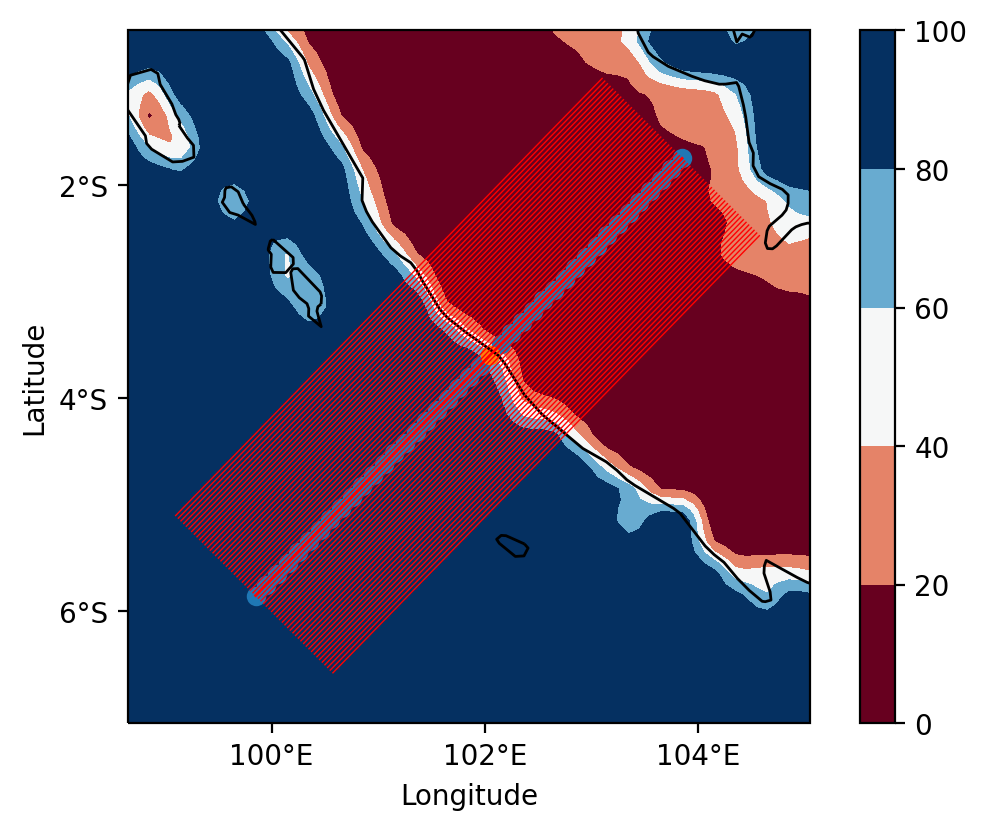

In [104]:
fig = plt.figure(figsize=(6.5,4.5))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

# d02_coords = dict(
#     south_north=('south_north',ds_d02.XLAT[0,:,0].values),
#     west_east=('west_east',ds_d02.XLONG[0,0,:].values)
#     )
# # # Terrain Height    [m]
# da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
# x = da_d02_TOPO.assign_coords(d02_coords)
width=0.75
lat = [all_line_coords[0,...].max()+0.5,all_line_coords[0,...].min()-0.5]
lon = [all_line_coords[1,...].min()-0.5,all_line_coords[1,...].max()+0.5]
# lat = [-2,-6]
# lon = [100,104]
# lat = np.add([-2,-6],0.2)
# lon = np.subtract([100,104],0.2)
# lat = np.add([0,-8],0.2)
# lon = np.subtract([98,106],0.2)
# Yokoi et al. 2017-2019 domain:
x = da_Mask_IMERG[0,...]
x = x.sel(
	lat=slice(lat[1],lat[0]),
	lon=slice(lon[0],lon[1]))
# x = x.sel(
# 	south_north=slice(lat[1]-(width*1.5),lat[0]+(width*1.5)),
# 	west_east=slice(lon[0]-(width*1.5),lon[1]+(width*1.5)))
x_ticks = np.array([100,102,104])
x_tick_labels = [u'100\N{DEGREE SIGN}E',
                 u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
y_ticks = np.array([-6,-4,-2])
y_tick_labels = [u'6\N{DEGREE SIGN}S',
                 u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']


# # Summatra domain:
# x = x.sel(
# 	south_north=slice(-7.5,7.5),
# 	west_east=slice(95,105))
# x_ticks = np.array([95,100,105])
# x_tick_labels = [u'95\N{DEGREE SIGN}E',
#                  u'100\N{DEGREE SIGN}E', u'105\N{DEGREE SIGN}E']
# y_ticks = np.array([-7.5,0,7.5])
# y_tick_labels = [u'7.5\N{DEGREE SIGN}S',
#                  u'0\N{DEGREE SIGN}N', u'7.5\N{DEGREE SIGN}N']
# lat = [5.5,-6.5]
# lon = [95.05,104.95]


ax1 = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=0))
ax1.coastlines(linewidth=1, color='k', resolution='50m')  # cartopy function
cf1 = x.plot.contourf(
	cmap='RdBu',
	# cmap='gray',
	# levels=np.arange()
	# levels=np.arange(0,4250,250),
	# levels = np.append(0,np.logspace(0,3.65,50))
)
dx = 0.025
# plt.plot(lon,lat,'y')
# plt.plot(lon,lat[::-1],'r',linewidth=1)
all_line_coords
for i in range(int(all_line_coords.shape[2])):
	# plt.plot(np.subtract(lon,i*dx),np.add(lat[::-1],i*dx),'r',linewidth=0.5)
	# plt.plot(np.add(lon,i*dx),np.subtract(lat[::-1],i*dx),'r',linewidth=0.5)
	plt.plot(all_line_coords[1,:,i],all_line_coords[0,:,i],'r',linewidth=0.5)
	# plt.plot(np.add(lon,i*dx),np.subtract(lat[::-1],i*dx),'r',linewidth=0.5)
plt.plot(all_line_coords[1,:,int(all_line_coords.shape[2]/2)],all_line_coords[0,:,int(all_line_coords.shape[2]/2)],'r',linewidth=1)
plt.scatter(all_line_coords[1,:,int(all_line_coords.shape[2]/2)],all_line_coords[0,:,int(all_line_coords.shape[2]/2)])
# Plot where you think the coastline will be
plt.scatter(all_line_coords[1,int(all_line_coords.shape[1]/2)-2,int(all_line_coords.shape[2]/2)],all_line_coords[0,int(all_line_coords.shape[1]/2)-2,int(all_line_coords.shape[2]/2)])

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('')
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels)


In [102]:
int(all_line_coords.shape[1]/2)-2

18

In [97]:
x = da_Mask_IMERG[0,...].interp(
	lat=da_d01_RR_cross.Lat[:,30].values,
	lon=da_d01_RR_cross.Lon[:,30].values
)

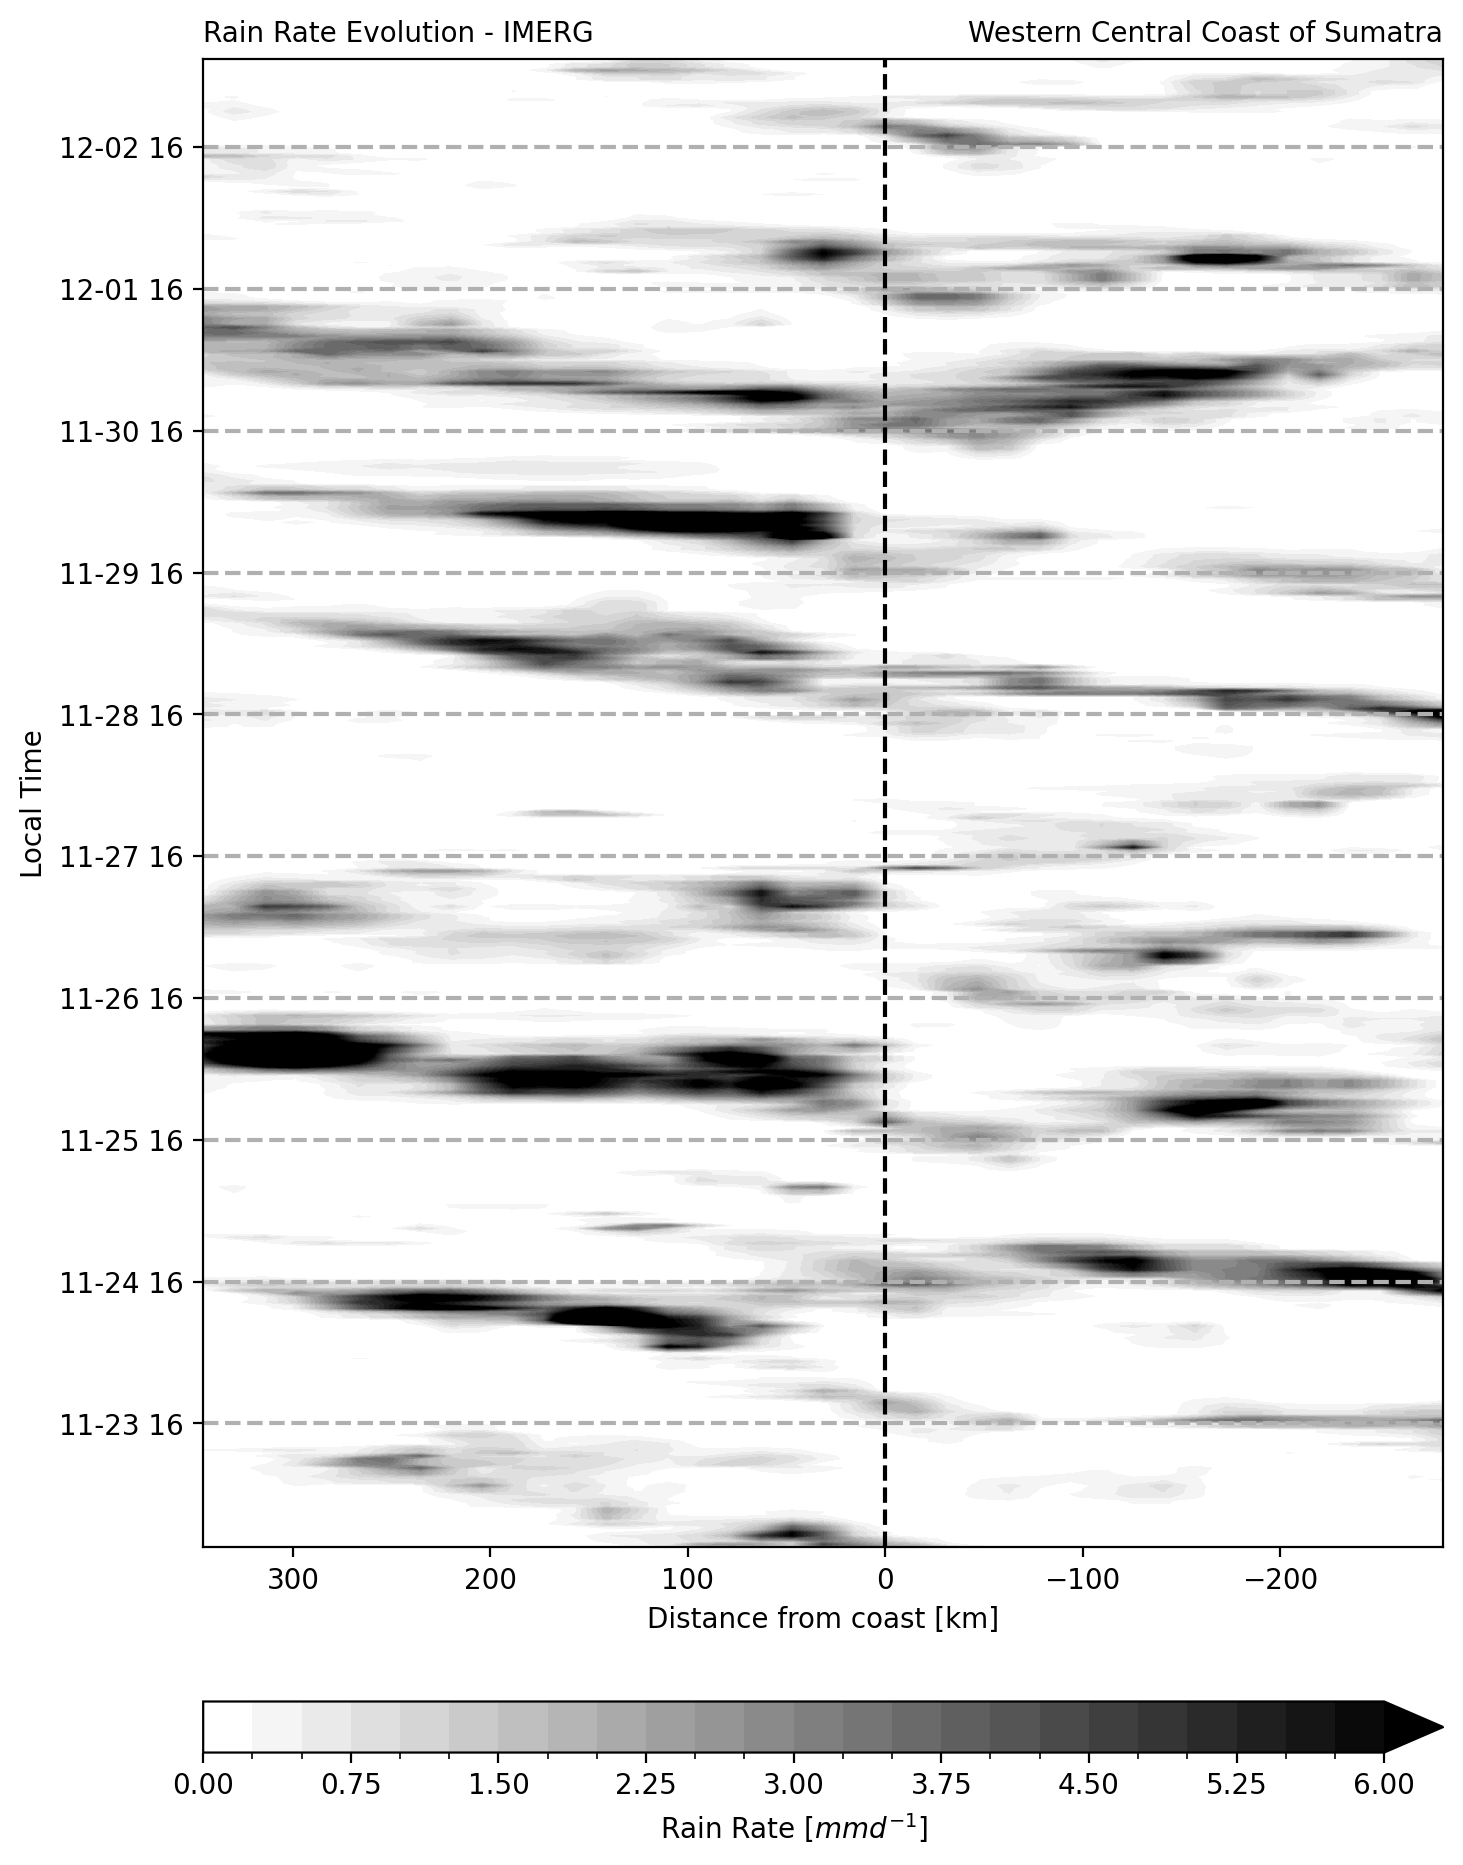

In [105]:
fig = plt.figure(figsize=(8,11))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.2, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])

# Data
	# Average over each cross-section
x1 = da_d01_RR_cross
x1 = x1.assign_coords({'Time':x1.Time + np.timedelta64(7,'h')})
x1 = x1.mean('Spread')

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	# levels=np.append(0,np.logspace(0,0.9,20)),
	cmap='gray_r',
	center=0,
)


# Plot the vertical line at approximate coastline
plt.axvline(x=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('Local Time')
ax1.invert_xaxis()
ax1.set_yticks(x1.Time[42::48].values)
ax1.set_yticklabels(x1.Time[42::48].dt.strftime("%m-%d %H").values)
# Set titles/labels
ax1.set_title('Rain Rate Evolution - IMERG', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
# Create grids
# ax1.grid(linestyle='--', axis='x', linewidth=1.5)
ax1.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Rain rate colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')


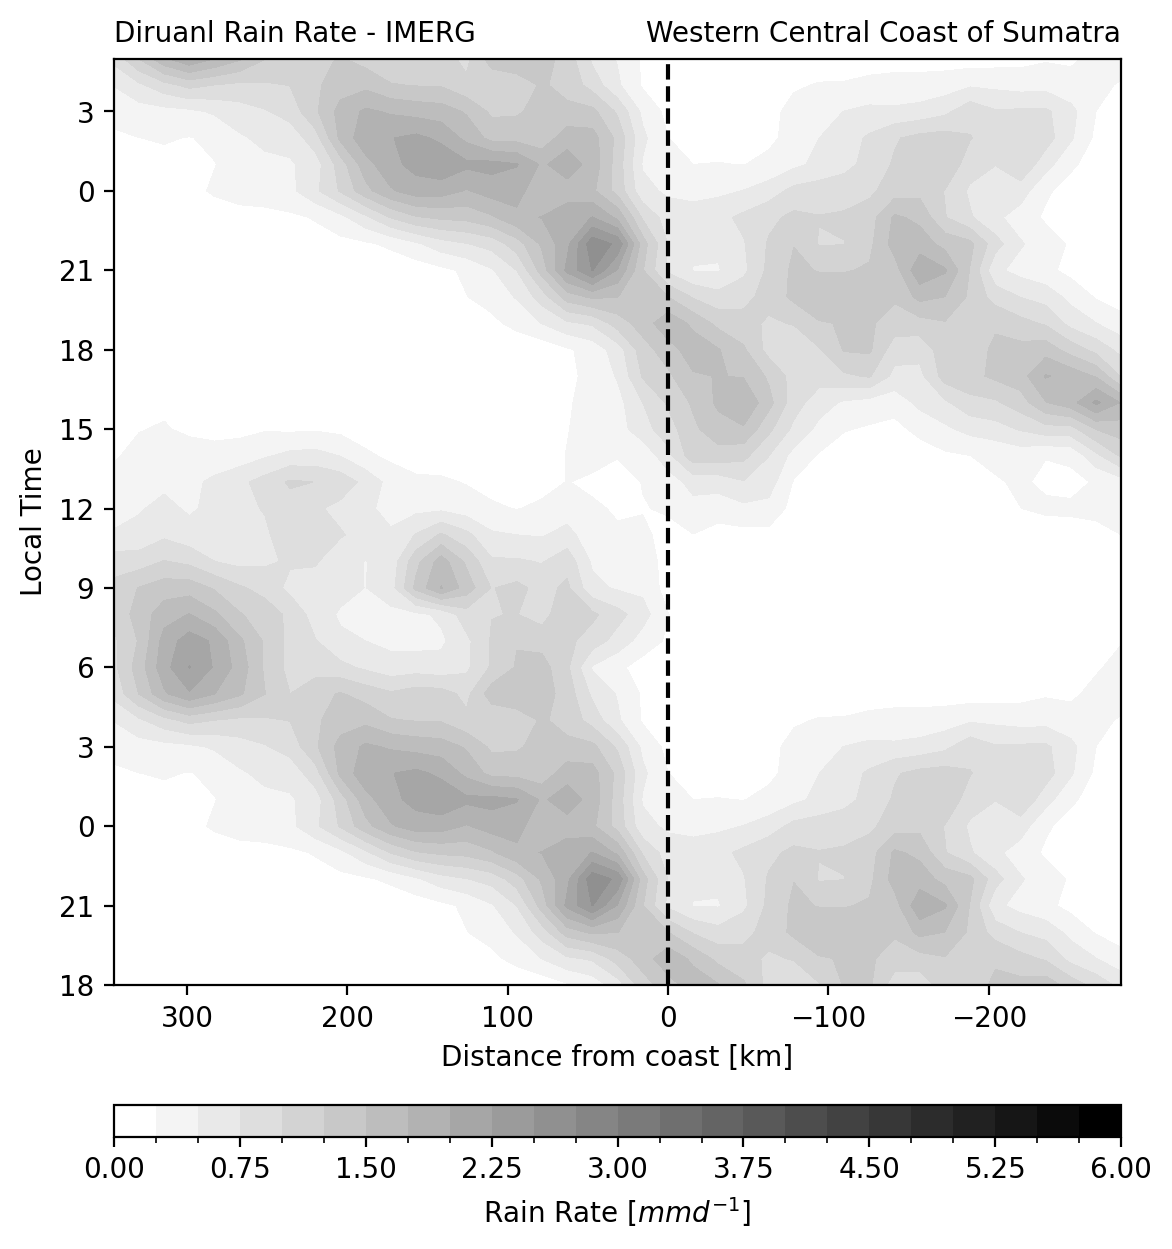

In [106]:
fig = plt.figure(figsize=(6.5,7))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])

# Data
	# Composite diurnally, and then average over each cross-section
x1 = da_d01_RR_cross
# Switch to local time
x1 = x1.assign_coords({'Time':x1.Time + np.timedelta64(7,'h')})
x1 = x1.groupby('Time.hour').mean().mean('Spread')
x2 = xr.concat([x1.isel(hour=slice(18,24)),x1,x1.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x2.hour.values
x2 = x2.assign_coords(hour=(['hour'],np.arange(-6,30)))

# Plot the cross-sectional data
cf1 = x2.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	# levels=np.append(0,np.logspace(0,0.75,20)),
	cmap='gray_r',
	center=0
)

# Plot the vertical line at approximate coastline
plt.axvline(x=0, color='k', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('Local Time')
ax1.invert_xaxis()
ax1.set_yticks(x2.hour[0::3].values)
ax1.set_yticklabels(yticks[0::3])
# Set titles/labels
ax1.set_title('Diruanl Rain Rate - IMERG', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100, extend='max')
cbar.set_label('Rain Rate [$mm d^{-1}$]')

